## Read and process data

In [1]:
from torch_geometric.datasets import PPI
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
from torch_geometric.loader import DataLoader

train_dataset = PPI(root='./data/PPI', split="train")
val_dataset = PPI(root='./data/PPI', split="val")
test_dataset = PPI(root='./data/PPI', split="test")

train_dataset.transform = T.NormalizeFeatures()
val_dataset.transform = T.NormalizeFeatures()
test_dataset.transform = T.NormalizeFeatures()

train_loader = iter(DataLoader(train_dataset, batch_size=len(train_dataset)))
val_loader = iter(DataLoader(val_dataset, batch_size=len(val_dataset)))
test_loader = iter(DataLoader(test_dataset, batch_size=len(test_dataset)))

train_set = next(train_loader)
test_set = next(test_loader)
val_set = next(val_loader)

In [2]:
complete_data = {"X_train": train_set.x,
                "X_test": test_set.x,
                "X_val": val_set.x,
                "y_train": train_set.y,
                "y_test": test_set.y,
                "y_val": val_set.y,
                "edge_index_train": train_set.edge_index,
                "edge_index_test": test_set.edge_index,
                "edge_index_val": val_set.edge_index}

## Search Hyperparameters

In [3]:
from hyperopt import hp
from xgboost import XGBClassifier

xb_choices = {
    'booster': ["gbtree"],
    'n_estimators': [1_400, 1_600, 1_800, 2_000],
    'max_depth': [None,2, 3,4],
    'max_delta_step': [1,2,3],
    'min_child_weight': [None, *list(range(1,5,1))],
    'device': ["cuda:2"],
    "tree_method": ["hist"],
    'scale_pos_weight': [((train_set.y == 0).sum() / (train_set.y == 1).sum()).item()]
}
 
space_xb = {
    **{key: hp.choice(key, value) for key, value in xb_choices.items()},
    'eta': hp.loguniform('eta', -3, -.4),
    'subsample': hp.uniform('subsample', 0.8, 1),#0.6
    'reg_lambda': hp.loguniform('reg_lambda',-5, 5),
    'reg_alpha': hp.loguniform('reg_alpha',-3, 1),#0.8
    'gamma': hp.uniform('gamma', 0, .2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.85, 1),
}

clfs_space = dict({})
clfs_space["XGBClassifier"] = space_xb
clfs = [XGBClassifier]

In [ ]:
from AutoTune2 import AutoSearch
from sklearn.metrics import f1_score

searcher = AutoSearch(complete_data, multi_target_class=True, max_evals=45, pred_metric = f1_score, pred_metric_kwargs={"average":"micro"},
                      is_transductive = False, parallelism = 8)
store = searcher.search(clfs, clfs_space, hops=[3])

In [11]:
store

{'XGBClassifier': {3: {'train_acc': 0.9977430847776764,
   'val_acc': 0.9773959159268455,
   'test_acc': 0.9846497334587644,
   'model': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.9983509027864691, device='cuda:2',
                 early_stopping_rounds=None, enable_categorical=False,
                 eta=0.24241545316243465, eval_metric=None, feature_types=None,
                 gamma=0.05633266483318489, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
                 max_depth=None, max_leaves=None, min_child_weight=None,
                 missing=nan, monotone_constraints=None, multi_strategy=None,
                 n_estimators=1400, n_jobs=None, num_parallel_tree=None, ...),
   'user_function': <function Auto

## Store hyperparameters permanently

In [8]:
from AutoTune2 import user_function
from xgboost import XGBClassifier

store = {3: {'train_acc': 0.9979866294463681,
   'val_acc': 0.9758037656002039,
   'test_acc': 0.9838136835582694,
   'model': XGBClassifier(**{'objective': 'binary:logistic',
 'base_score': None,
 'booster': 'gbtree',
 'colsample_bytree': 0.9983509027864691,
 'device': 'cuda:2',
 'gamma': 0.05633266483318489,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 1,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.06653159168960418,
 'reg_lambda': 0.02308162322280471,
 'sampling_method': None,
 'scale_pos_weight': 2.252702236175537,
 'subsample': 0.9956436486105597,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.24241545316243465,
                            'early_stopping_rounds': 10,
                            "eval_metric":"error"
                            }),
   'user_function': user_function,
   'attention_config': {'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}}
}

## GraphAware - Evaluation

In [9]:
from EnsembleFramework import Framework
from AutoTune2 import user_function
hops =  [3]
framework = Framework(hops_list= hops,
                      clfs=[store[i]["model"] for i in hops],
                      attention_configs=[store[i]["attention_config"] for i in hops],
                      handle_nan=0.0,
                      gpu_idx=0,
                      user_functions=[store[i]["user_function"] for i in hops]
                      )

In [10]:
from tqdm.notebook import tqdm
import time
import numpy as np
import torch
from sklearn.metrics import f1_score

times = []
scores = []
ITERATIONS = 1
for i in tqdm(range(ITERATIONS)):
    start = time.time()
    def transform_kwargs_fit(framework, kwargs, i):
        val_out = framework.get_features(val_set.x, val_set.edge_index, torch.ones(val_set.x.shape[0]).type(torch.bool), is_training = False)[0].cpu()    
        return {"eval_set":[(val_out, val_set.y)], "verbose":False}
        
    framework.fit(X_train=train_set.x, edge_index=train_set.edge_index,y_train=train_set.y, train_mask=torch.ones(train_set.x.shape[0]).type(torch.bool),
                 transform_kwargs_fit = transform_kwargs_fit)
    elapsed_time = time.time() - start
    predict_proba = framework.predict_proba(test_set.x, test_set.edge_index, torch.ones(test_set.x.shape[0]).type(torch.bool))
    score = f1_score(test_set.y, np.round(predict_proba), average ="micro")
    scores.append(score)
    times.append(elapsed_time)   

  0%|          | 0/1 [00:00<?, ?it/s]

/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:160: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")
/home/dwalke/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:37:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:2, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [22]:
scores = np.array(scores)
times = np.array(times)
print(f"F1-Micro is {scores.mean()}+-{scores.std()}; Required training time is: {times.mean()}+-{times.std()}")

F1-Micro is 0.9838814782318904+-0.00022475508435411922; Required training time is: 149.87999074459077+-7.572227816215075


## Feature importance calculation

In [13]:
framework.feature_importance()

array([0.01924938, 0.01910766, 0.01912091, 0.0193457 , 0.01824162,
       0.0204236 , 0.01810137, 0.01878868, 0.01838496, 0.02142961,
       0.02532204, 0.01807901, 0.01903244, 0.01923802, 0.01915025,
       0.01947404, 0.01987461, 0.01917948, 0.01992037, 0.01846377,
       0.01961845, 0.01931971, 0.02005534, 0.01994174, 0.01731976,
       0.01908039, 0.01880015, 0.0205507 , 0.01913141, 0.01971542,
       0.01905106, 0.01963227, 0.020801  , 0.01922891, 0.02336204,
       0.02463376, 0.01973318, 0.01971647, 0.01934644, 0.02117537,
       0.01972008, 0.02041284, 0.0209612 , 0.01841985, 0.02018405,
       0.01777514, 0.02308099, 0.0215361 , 0.02657736, 0.0211913 ],
      dtype=float32)

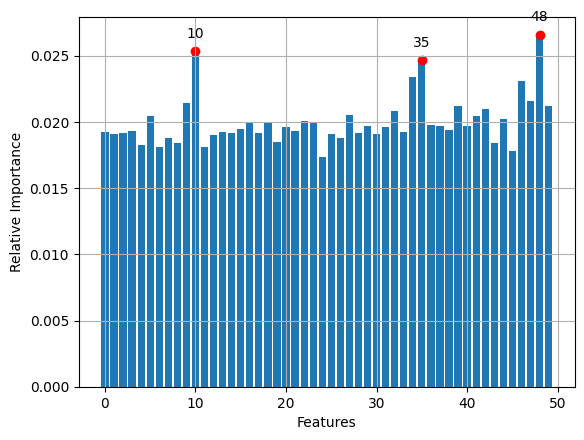

In [14]:
framework.plot_feature_importances()